In [1]:
import pandas as pd

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge

from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from scipy import stats

import os

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import vapeplot
import numpy as np

vapeplot.set_palette('cool')
plt.rc('axes', grid=False, facecolor="white")
plt.rcParams.update({'font.size': 18})

Processing encoder:  prottrans_t5_uniref.csv
Processing encoder:  prottrans_albert.csv
Processing encoder:  esm1v.csv
Processing encoder:  prottrans_t5_xlu50.csv
Processing encoder:  prottrans_bert.csv
Processing encoder:  prottrans_t5bdf.csv
Processing encoder:  prottrans_xlnet.csv


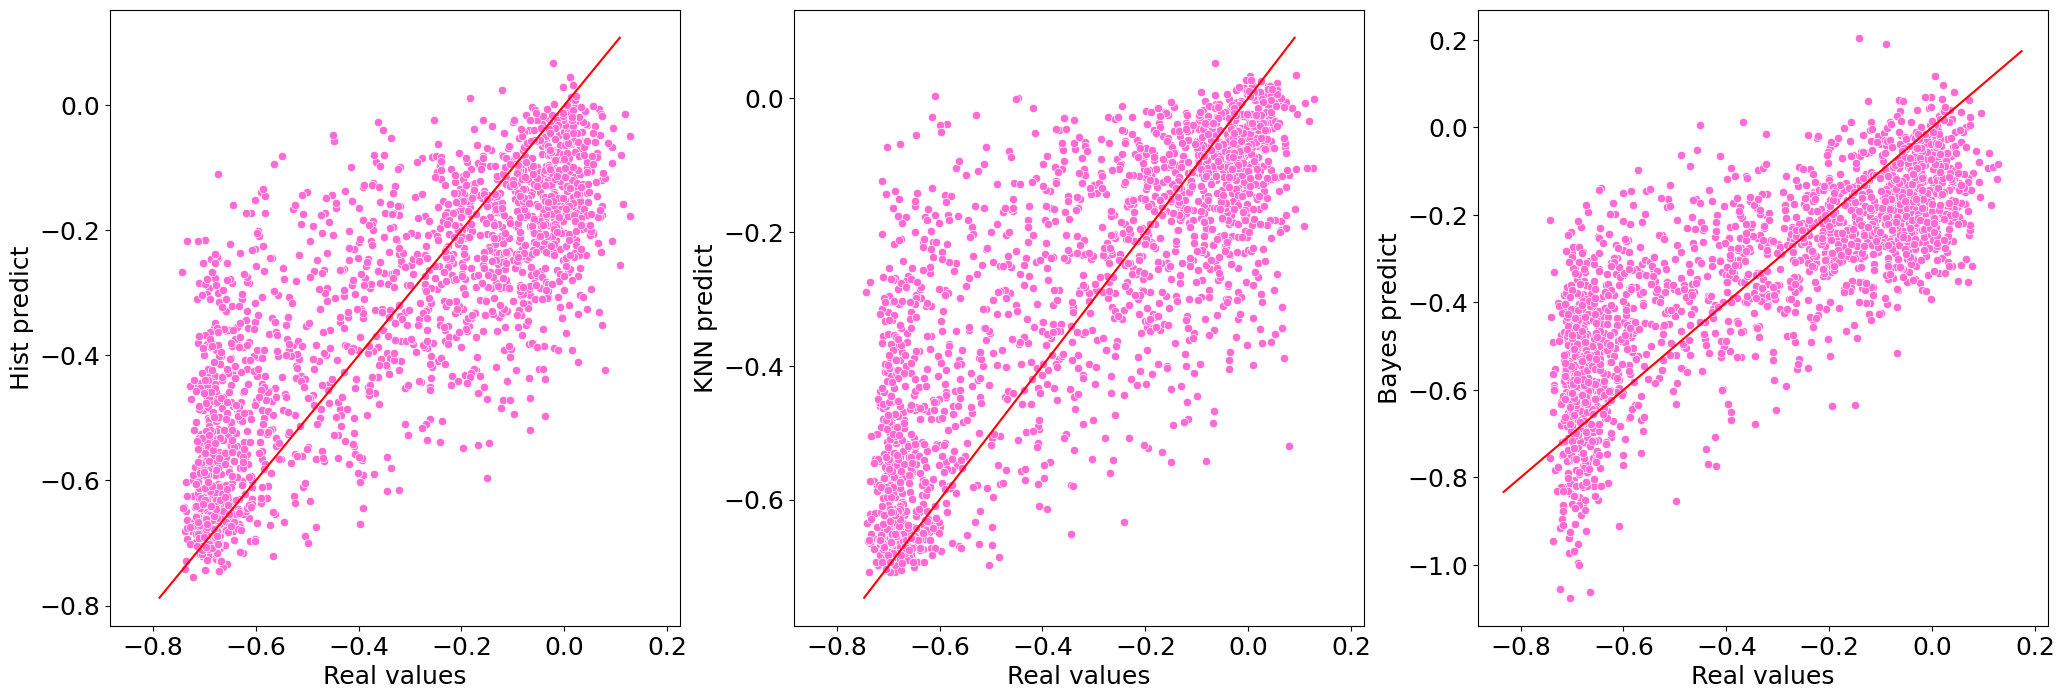

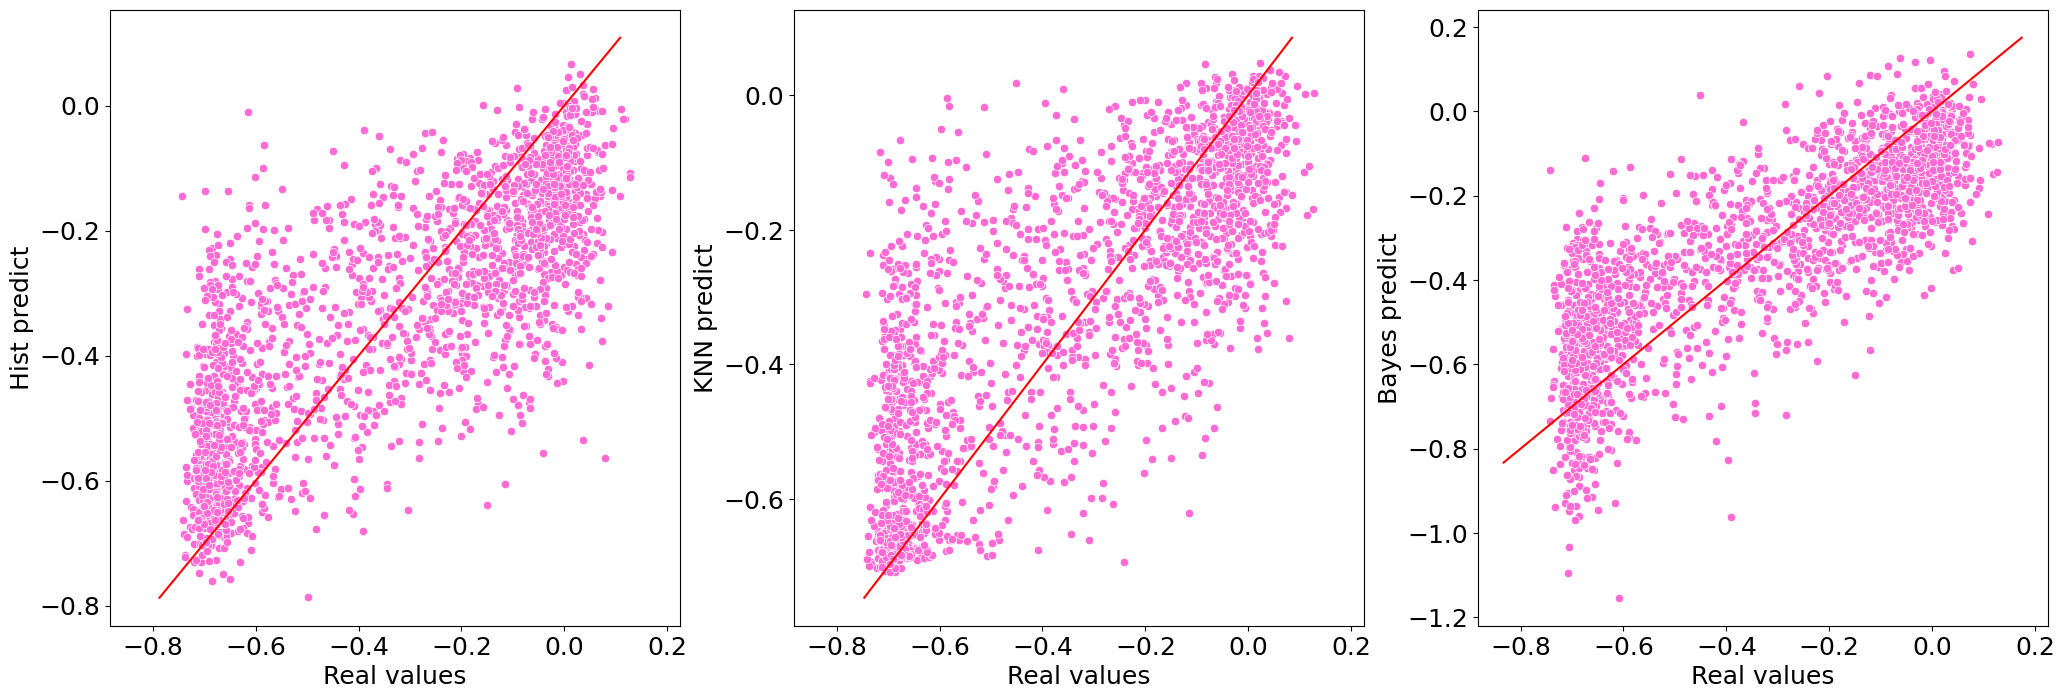

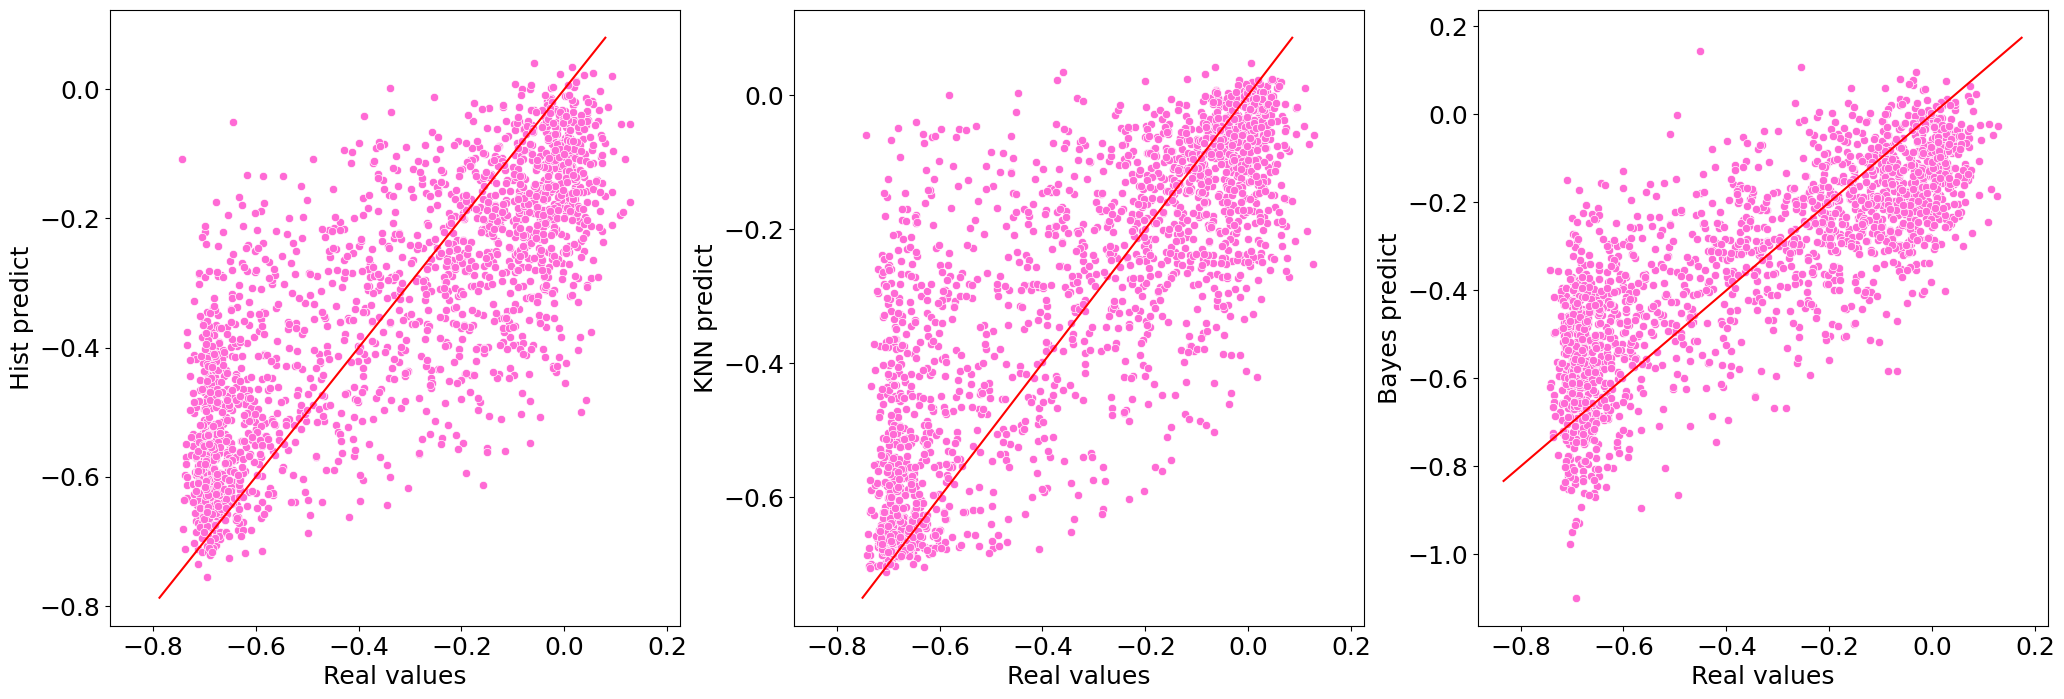

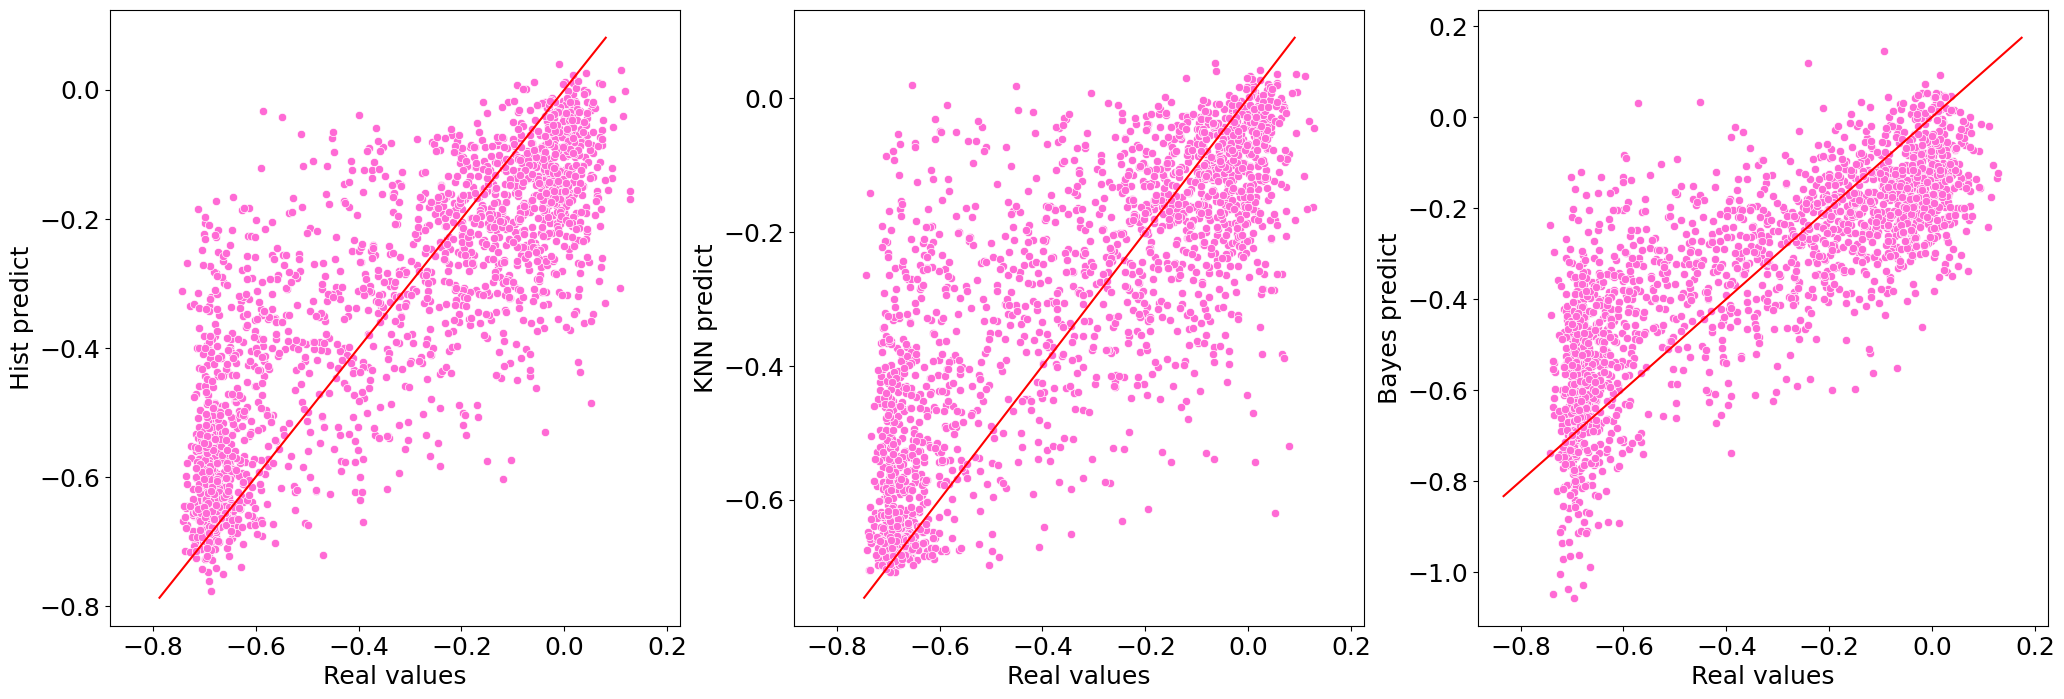

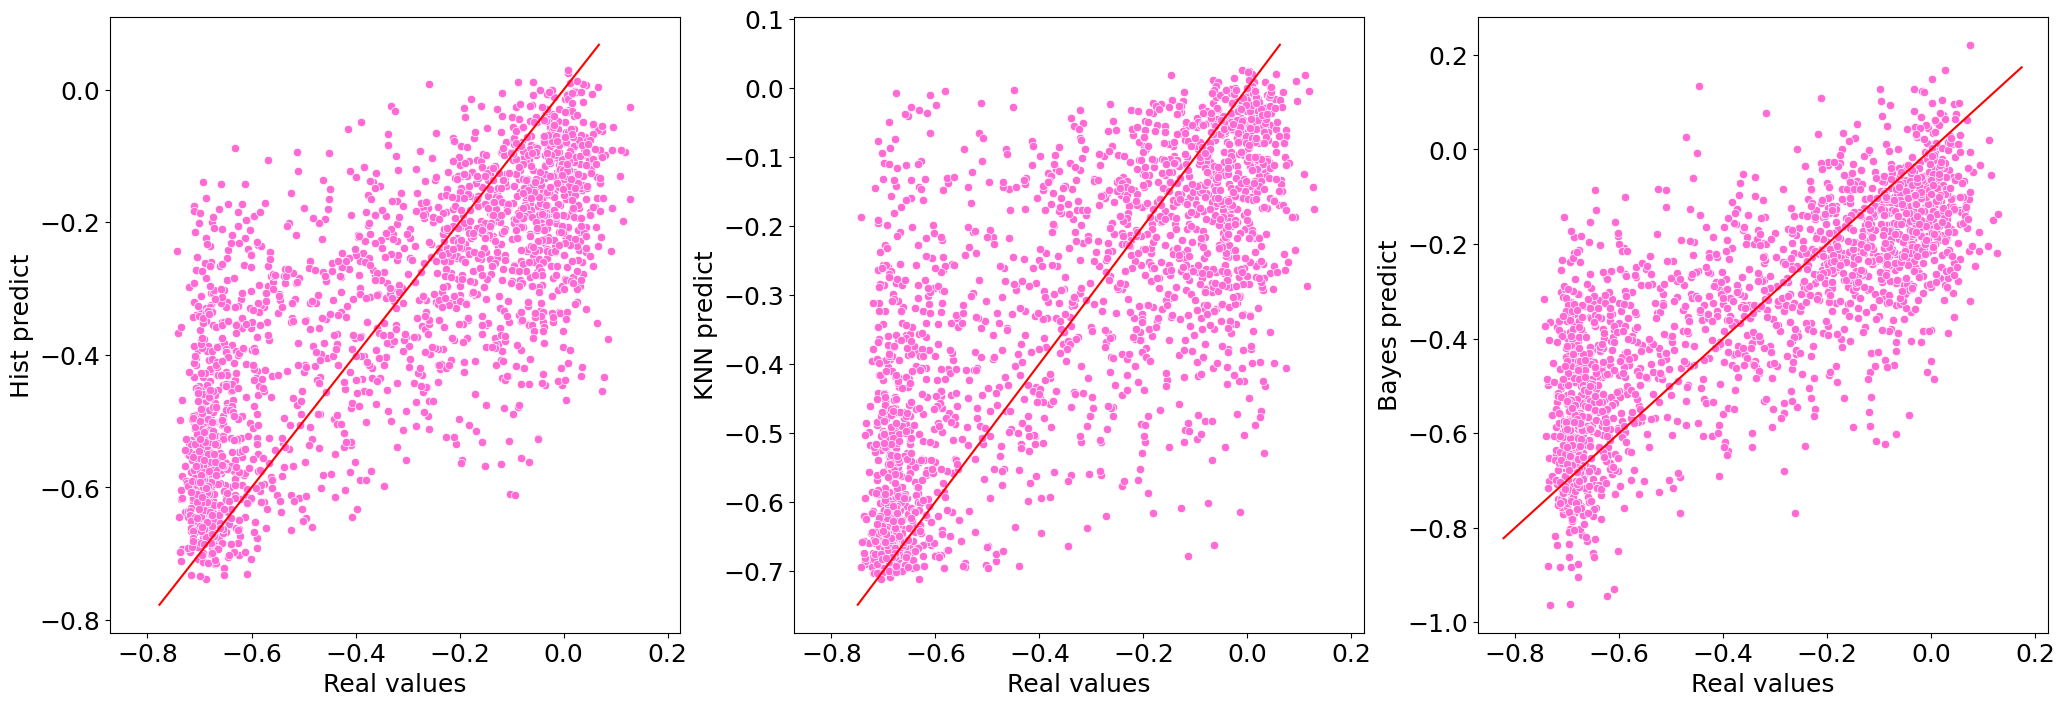

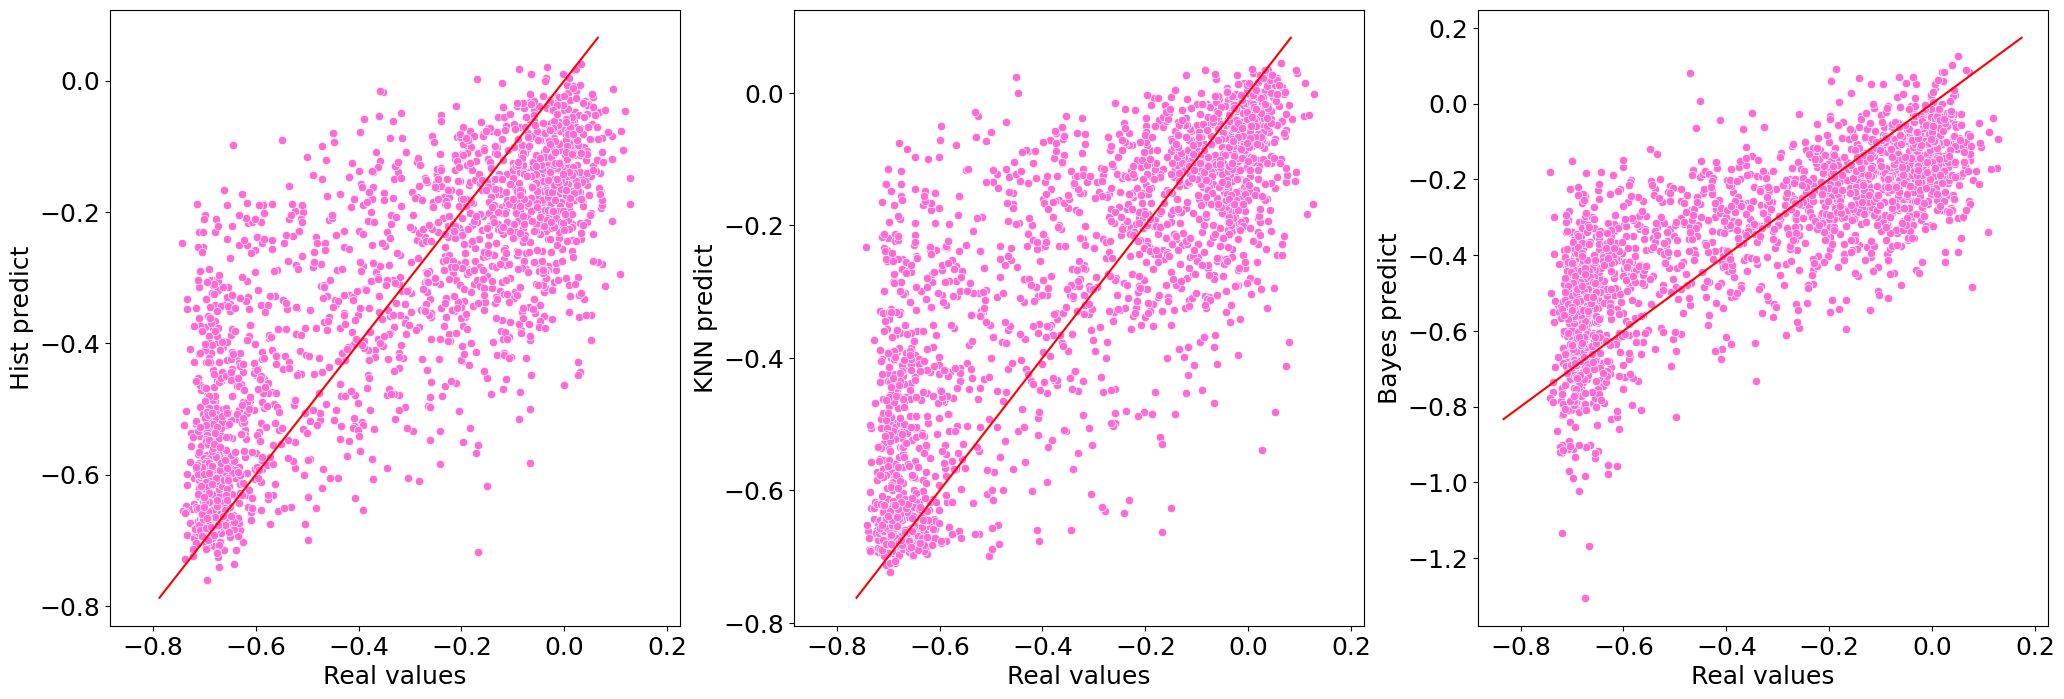

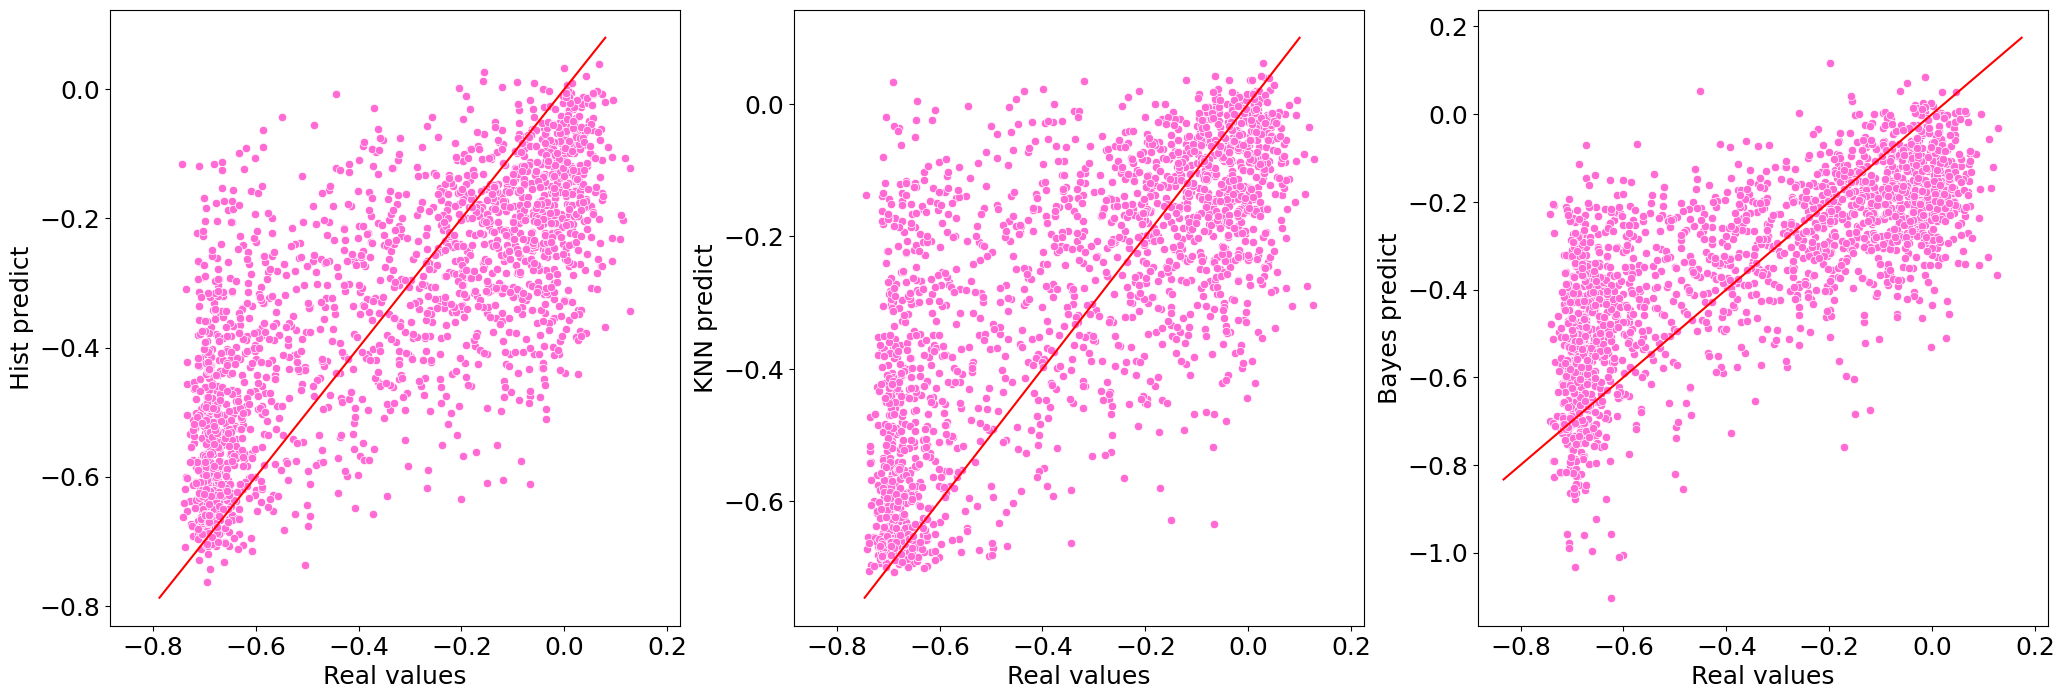

In [3]:
list_df_summary = []

for encoder in os.listdir("../../selected_dataset/"):

    print("Processing encoder: ", encoder)
    name_encoder = encoder.split(".")[0]

    df_data = pd.read_csv(f"../../selected_dataset/{encoder}")

    response = df_data["activity"]
    df_to_train = df_data.drop(columns=['expression', "activity"])

    X_train, X_test, y_train, y_test = train_test_split(df_to_train, response, random_state=42, test_size=0.3)

    hist_model = HistGradientBoostingRegressor()
    knn_model = KNeighborsRegressor()
    bayes_model = BayesianRidge()

    hist_model.fit(X=X_train, y=y_train)
    knn_model.fit(X=X_train, y=y_train)
    bayes_model.fit(X=X_train, y=y_train)

    predictions_hist = hist_model.predict(X=X_test)
    predictions_knn = knn_model.predict(X=X_test)
    predictions_bayes = bayes_model.predict(X_test)

    methods = ["hist-gradient", "knn", "bayes"]

    r2_values = [
        r2_score(y_true=y_test, y_pred=predictions_hist),
        r2_score(y_true=y_test, y_pred=predictions_knn),
        r2_score(y_true=y_test, y_pred=predictions_bayes)
    ]

    mse_values = [
        mean_squared_error(
            y_pred=predictions_hist,
            y_true=y_test
        ),
        mean_squared_error(
            y_pred=predictions_knn,
            y_true=y_test
        ),
        mean_squared_error(
            y_pred=predictions_bayes,
            y_true=y_test
        )
    ]

    rmse_values = [
        root_mean_squared_error(
            y_pred=predictions_hist,
            y_true=y_test
        ),
        root_mean_squared_error(
            y_pred=predictions_knn,
            y_true=y_test
        ),
        root_mean_squared_error(
            y_pred=predictions_bayes,
            y_true=y_test
        )
    ]

    spearman_values = [
        stats.spearmanr(y_test, predictions_hist)[0],
        stats.spearmanr(y_test, predictions_knn)[0],
        stats.spearmanr(y_test, predictions_bayes)[0],
    ]

    df_summary = pd.DataFrame()
    df_summary["method"] = methods
    df_summary["r2"] = r2_values
    df_summary["mse"] = mse_values
    df_summary["rmse"] = rmse_values
    df_summary["spearman"] = spearman_values
    df_summary["encoder"] = name_encoder

    df_summary_predictions = pd.DataFrame()
    df_summary_predictions["Real values"] = y_test
    df_summary_predictions["Hist predict"] = predictions_hist
    df_summary_predictions["KNN predict"] = predictions_knn
    df_summary_predictions["Bayes predict"] = predictions_bayes

    fig, axes = plt.subplots(1,3, figsize=(25,8), sharex=True)

    g1 = sns.scatterplot(ax=axes[0], data=df_summary_predictions, x="Real values", y="Hist predict")

    x0, x1 = g1.get_xlim()
    y0, y1 = g1.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g1.plot(lims, lims, '-r')

    g2 = sns.scatterplot(ax=axes[1], data=df_summary_predictions, x="Real values", y="KNN predict")

    x0, x1 = g2.get_xlim()
    y0, y1 = g2.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g2.plot(lims, lims, '-r')

    g3 = sns.scatterplot(ax=axes[2], data=df_summary_predictions, x="Real values", y="Bayes predict")

    x0, x1 = g3.get_xlim()
    y0, y1 = g3.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g3.plot(lims, lims, '-r')

    plt.savefig(f"../../results_selected_models/activity/summary_{name_encoder}.png")

    list_df_summary.append(df_summary)

In [5]:
df_summary_performances = pd.concat(list_df_summary, axis=0)
df_summary_performances.to_csv("../../results_selected_models/activity/summary_best_model.csv", index=False)